In [4]:
import pandas as pd
!pip install shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.3 MB/s eta 0:00:00


# **Details About the Dataset**
 ***Census Income***

 Kohavi,Ron. (1996). Census Income. UCI Machine Learning Repository. https://doi.org/10.24432/C5GP7S.

Predict whether income exceeds $50K/yr based on census data.



This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.

This allows for the sharing and adaptation of the datasets for any purpose, provided that the appropriate credit is given.

---

Instances - 48842

Features - 14


#Importing the Dataset from **UCI**




In [5]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

census_income = fetch_ucirepo(id=20)

# data (as pandas dataframes)
X = census_income.data.features
y = census_income.data.targets

# metadata
print(census_income.metadata)

# variable information
print(census_income.variables)

''' Source: https://github.com/uci-ml-repo/ucimlrepo '''

{'uci_id': 20, 'name': 'Census Income', 'repository_url': 'https://archive.ics.uci.edu/dataset/20/census+income', 'data_url': 'https://archive.ics.uci.edu/static/public/20/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data.  Also known as Adult dataset.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5GP7S', 'creators': ['Ron Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && 

' Source: https://github.com/uci-ml-repo/ucimlrepo '

In [6]:
y['income'].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

''' There is some noise in the dataset with fullstop "." which makes the pre-defined function to believe it as it has 4 unique variable , whereas it only has 2.'''


# Converting the noisy data in the dependent variable



In [7]:
y_mod= y['income']
for i in range(len(y_mod)):
  if y_mod[i]=="<=50K.":
    y_mod[i]="<=50K"
  if y_mod[i]==">50K.":
    y_mod[i]=">50K"

<ipython-input-7-f254aeabb6de>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_mod[i]="<=50K"
<ipython-input-7-f254aeabb6de>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_mod[i]=">50K"


In [8]:
# This converts the array into dataframe
Y=y_mod.to_frame(name='income')


**Now Let's handle numerical features in dependent variables**

#Finding and handling the Missing data


Convert empty data to standard null values

In [9]:
X.replace({'?':np.nan},inplace=True)

<ipython-input-9-37eaac7aa2c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace({'?':np.nan},inplace=True)


In [10]:
#Finding Total missing values
X.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

Using Mode value method to fill-in the missing values ( which uses highest occurrence value )




In [11]:
X['workclass'].fillna(X['workclass'].mode().values[0],inplace=True)
X['occupation'].fillna(X['occupation'].mode().values[0],inplace=True)
X['native-country'].fillna(X['native-country'].mode().values[0],inplace=True)

<ipython-input-11-112f24929e45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['workclass'].fillna(X['workclass'].mode().values[0],inplace=True)
<ipython-input-11-112f24929e45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['occupation'].fillna(X['occupation'].mode().values[0],inplace=True)
<ipython-input-11-112f24929e45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['native-country'].fillna(X['native-country'].mode().valu

In [12]:
X.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

#Preprocess of Dataset

In [13]:
df=X.copy(deep=True)

In [14]:
columns_to_encode = [ 'workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

for col in columns_to_encode:
    df[col] = df[col].astype(str)


In [15]:
df=df.drop(columns=columns_to_encode)

In [16]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
encoded_df = pd.DataFrame(encoder.fit_transform(X[columns_to_encode]), columns=encoder.get_feature_names_out())
df = pd.concat([df, encoded_df], axis=1)

In [17]:
from sklearn.preprocessing import LabelEncoder

column_to_encode = ['income']
l = LabelEncoder()
for column in column_to_encode:
    Y[column] = l.fit_transform(Y[column])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, shuffle=False)

In [19]:
data=pd.concat([df,Y],axis=1)
inde=df.columns

In [20]:
data=data.dropna()

In [21]:
data.reset_index(drop=True)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,39,77516,13,2174,0,40,6.0,9.0,4.0,0.0,1.0,4.0,1.0,38.0,0
1,50,83311,13,0,0,13,5.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0,0
2,38,215646,9,0,0,40,3.0,11.0,0.0,5.0,1.0,4.0,1.0,38.0,0
3,53,234721,7,0,0,40,3.0,1.0,2.0,5.0,0.0,2.0,1.0,38.0,0
4,28,338409,13,0,0,40,3.0,9.0,2.0,9.0,5.0,2.0,0.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,13,0,0,36,3.0,9.0,0.0,9.0,1.0,4.0,0.0,38.0,0
48838,64,321403,9,0,0,40,3.0,11.0,6.0,9.0,2.0,2.0,1.0,38.0,0
48839,38,374983,13,0,0,50,3.0,9.0,2.0,9.0,0.0,4.0,1.0,38.0,0
48840,44,83891,13,5455,0,40,3.0,9.0,0.0,0.0,3.0,1.0,1.0,38.0,0


#Logistic Regression

In [22]:
import statsmodels.api as sm
model = sm.Logit(y_train,X_train,).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.412155
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                39073
Model:                          Logit   Df Residuals:                    39059
Method:                           MLE   Df Model:                           13
Date:                Mon, 18 Mar 2024   Pseudo R-squ.:                  0.2521
Time:                        02:59:56   Log-Likelihood:                -16104.
converged:                       True   LL-Null:                       -21533.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
age                0.0095      0.001      8.822      0.000       0.007       0.012
fnlwgt         -1.085e-06   1.35e-07     -8.054      0.000   -1.35e-06   -8.21e-07
education-num      0.2322      0.006     40.415      0.000       0.221       0.243
capital-gain       0.0003   8.55e-06     37.449      0.000       0.000       0.000
capital-loss       0.0007   2.94e-05     24.451      0.000       0.001       0.001
hours-per-week     0.0106      0.001      9.141      0.000       0.008       0.013
workclass         -0.1928      0.012    -16.515      0.000      -0.216      -0.170
education         -0.0316      0.004     -7.700      0.000      -0.040      -0.024
marital-status    -0.3603      0.011    -34.124      0.000      -0.381      -0.340
occupation        -0.0216      0.004     -6.134      0.000      -0.028      -0.015
relationship      -0.3467      0.012    -28.214      0.000      -0.371      -0.323
race              -0.1637      0.016    -10.432      0.000      -0.194      -0.133
sex                0.3326      0.041      8.077      0.000       0.252       0.413
native-country    -0.0495      0.002    -25.661      0.000      -0.053      -0.046
==================================================================================
"""

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

auc = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc)

<ipython-input-20-e5778811dafd>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


AUC Score: 0.7746351843874708


<BarContainer object of 14 artists>

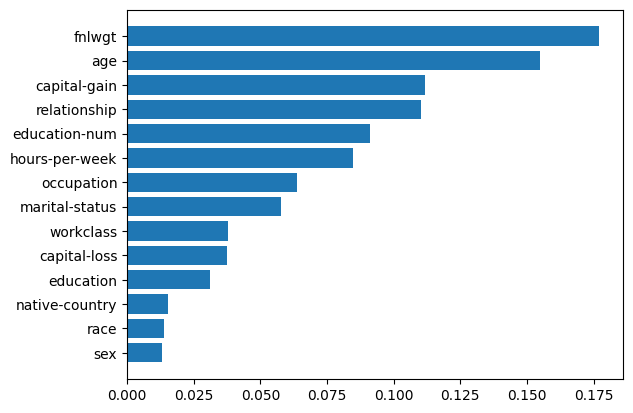

In [ ]:
result = sorted(zip(inde, clf.feature_importances_), key = lambda x: x[1], reverse=False)
plt.barh([x[0] for x in result], [x[1] for x in result])

In [27]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 1.4 MB/s eta 0:00:00


In [28]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import pearsonr

In [29]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score, mean_squared_error
from sklearn import metrics



In [30]:
min_mem_size = 6
run_time = 222
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

6


In [31]:
port_no = random.randint(5555, 55555)
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )
except:
    logging.critical("h2o.init")
    h2o.download_all_logs()
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:40672..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_q8guve9
  JVM stdout: /tmp/tmp_q8guve9/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_q8guve9/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:40672
Connecting to H2O server at http://127.0.0.1:40672 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_vdm23k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [32]:
data = h2o.H2OFrame(data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [33]:
for column in columns_to_encode:
    data[column] = data[column].asfactor()
data['income']=data['income'].asfactor()

In [34]:
pct_rows = 0.80
df_train, df_test= data.split_frame([pct_rows])
#Removing Dependent from dataset
X = data.columns
X.remove('income')

In [35]:
automl = H2OAutoML(max_models = 10, seed = 10, sort_metric='AUC', verbosity="info")
automl.train(x=X, y='income', training_frame=df_train)

AutoML progress: |
03:13:48.747: Project: AutoML_1_20240318_31348
03:13:48.749: 5-fold cross-validation will be used.
03:13:48.750: Setting stopping tolerance adaptively based on the training frame: 0.005060518789482428
03:13:48.750: Build control seed: 10
03:13:48.751: training frame: Frame key: AutoML_1_20240318_31348_training_py_11_sid_8e61    cols: 15    rows: 39049  chunks: 1    size: 601178  checksum: 3810003780994972704
03:13:48.751: validation frame: NULL
03:13:48.752: leaderboard frame: NULL
03:13:48.752: blending frame: NULL
03:13:48.752: response column: income
03:13:48.752: fold column: null
03:13:48.752: weights column: null
03:13:48.818: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (7g, 10w)]}, {Dee

key,value
Stacking strategy,cross_validation
Number of base models (used / total),7/10
# GBM base models (used / total),3/4
# XGBoost base models (used / total),3/3
# DRF base models (used / total),1/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [36]:
best_model = automl.leader
best_model.model_performance(df_test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.086815222287823
RMSE: 0.294644230026354
LogLoss: 0.2745325216417191
AUC: 0.9296040962426683
AUCPR: 0.8292085211453674
Gini: 0.8592081924853365
Null degrees of freedom: 9792
Residual degrees of freedom: 9785
Null deviance: 10732.71236263625
Residual deviance: 5376.993968874711
AIC: 5392.993968874711

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.378678395332515
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      6719  750   0.1004   (750.0/7469.0)
1      547   1777  0.2354   (547.0/2324.0)
Total  7266  2527  0.1324   (1297.0/9793.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378678     0.732632  202
max f2                       0.176849     0.812179  280
max f0point5                 0.666437     0.76874   103
max accuracy                 0.485939     0.875115  164
max precision                0.997565     1         0
max recall                   0.00178235   1         397
max specificity              0.997565     1         0
max absolute_mcc             0.378678     0.645814  202
max min_per_class_accuracy   0.272585     0.847771  243
max mean_per_class_accuracy  0.253621     0.851256  250
max tns                      0.997565     7469      0
max fns                      0.997565     2276      0
max fps                      0.000956893  7469      399
max tps                      0.00178235   2324      397
max tnr                      0.997565     1         0
max fnr                      0.997565     0.979346  0
max fpr                      0.000956893  1         399
max tpr                      0.00178235   1         397

Gains/Lift Table: Avg response rate: 23.73 %, avg score: 23.72 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100071                   0.99604            4.21386     4.21386            1                0.997054    1                           0.997054            0.0421687       0.0421687                  321.386   321.386            0.0421687
2        0.0200143                   0.994215           4.21386     4.21386            1                0.995227    1                           0.996141            0.0421687       0.0843373                  321.386   321.386            0.0843373
3        0.0300214                   0.990512           4.21386     4.21386            1                0.99257     1                           0.99495             0.0421687       0.126506                   321.386   321.386            0.126506
4        0.0400286                   0.983061           4.21386     4.21386            1                0.987035    1                           0.992971            0.0421687       0.168675                   321.386   321.386            0.168675
5        0.0500357                   0.971221           4.12786     4.19666            0.979592         0.977185    0.995918                    0.989814            0.0413081       0.209983                   312.786   319.666            0.209715
6        0.100071                    0.767419           3.62048     3.90857            0.859184         0.854499    0.927551                    0.922156            0.181153        0.391136                   262.048   290.857            0.38163
7        0.150005                    0.640582           2.95573     3.59139            0.701431         0.705577    0.8

In [37]:
aml_leaderboard_df = automl.leaderboard.as_data_frame()
aml_leaderboard_df

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
0,StackedEnsemble_AllModels_1_AutoML_1_20240318_...,0.928925,0.276327,0.830107,0.172218,0.296444,0.087879
1,StackedEnsemble_BestOfFamily_1_AutoML_1_202403...,0.928773,0.276450,0.829945,0.173178,0.296500,0.087912
2,GBM_3_AutoML_1_20240318_31348,0.927481,0.279424,0.827132,0.176316,0.297975,0.088789
3,GBM_2_AutoML_1_20240318_31348,0.927407,0.279514,0.827182,0.166970,0.297865,0.088724
4,XGBoost_3_AutoML_1_20240318_31348,0.927276,0.278674,0.827551,0.172090,0.297626,0.088581
5,GBM_4_AutoML_1_20240318_31348,0.926333,0.281483,0.824654,0.172716,0.299175,0.089506
6,GBM_1_AutoML_1_20240318_31348,0.924420,0.284752,0.820585,0.172325,0.300931,0.090560
7,XGBoost_2_AutoML_1_20240318_31348,0.922750,0.287794,0.816563,0.175539,0.303125,0.091885
8,XGBoost_1_AutoML_1_20240318_31348,0.921368,0.291116,0.812653,0.180012,0.304982,0.093014
9,DRF_1_AutoML_1_20240318_31348,0.914109,0.311637,0.800533,0.190970,0.309383,0.095718


In [38]:
best_model.algo

'stackedensemble'

In [39]:
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20240318_31348


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  7/10
# GBM base models (used / total)      3/4
# XGBoost base models (used / total)  3/3
# DRF base models (used / total)      1/2
# GLM base models (used / total)      0/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07448548819189058
RMSE: 0.27292029640884274
LogLoss: 0.23698557734572828
AUC: 0.9506309965482923
AUCPR: 0.8753774255579578
Gini: 0.9012619930965846
Null degrees of freedom: 10046
Residual degrees of

In [ ]:
print(best_model.auc(train=True))

0.9485874085759357


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


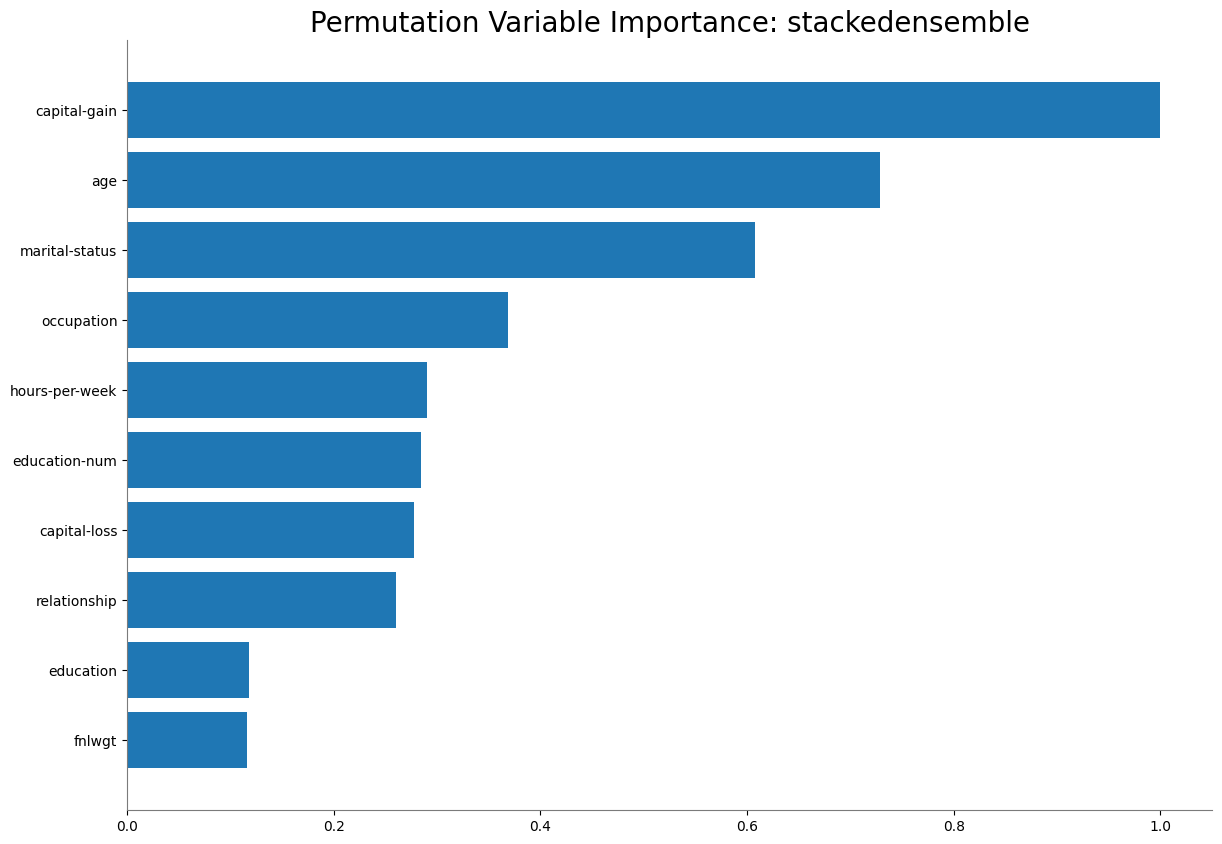

Variable,Relative Importance,Scaled Importance,Percentage
capital-gain,0.0545341,1.0,0.2333203
age,0.0397306,0.7285458,0.1699845
marital-status,0.0331294,0.6074994,0.1417419
occupation,0.0201100,0.3687602,0.0860392
hours-per-week,0.0158215,0.2901212,0.0676912
education-num,0.0155110,0.2844269,0.0663626
capital-loss,0.0151261,0.2773702,0.0647161
relationship,0.0141706,0.2598488,0.0606280
education,0.0064459,0.1182000,0.0275785
fnlwgt,0.0063062,0.1156373,0.0269805


In [ ]:
permutation_varimp = best_model.permutation_importance(df_train, use_pandas=True)
best_model.permutation_importance_plot(df_train)


#SHAP Values for Random Forest

In [ ]:
pipeline_r = Pipeline([
    ('clf', clf)
])
p = pipeline_r.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [50]:
explainer1 = shap.Explainer(pipeline_r.predict, X_train)
shap_values1 = explainer1(X_test)

PermutationExplainer explainer: 9770it [1:55:37,  1.41it/s]


In [ ]:
X_test.values.shape

(9769, 14)

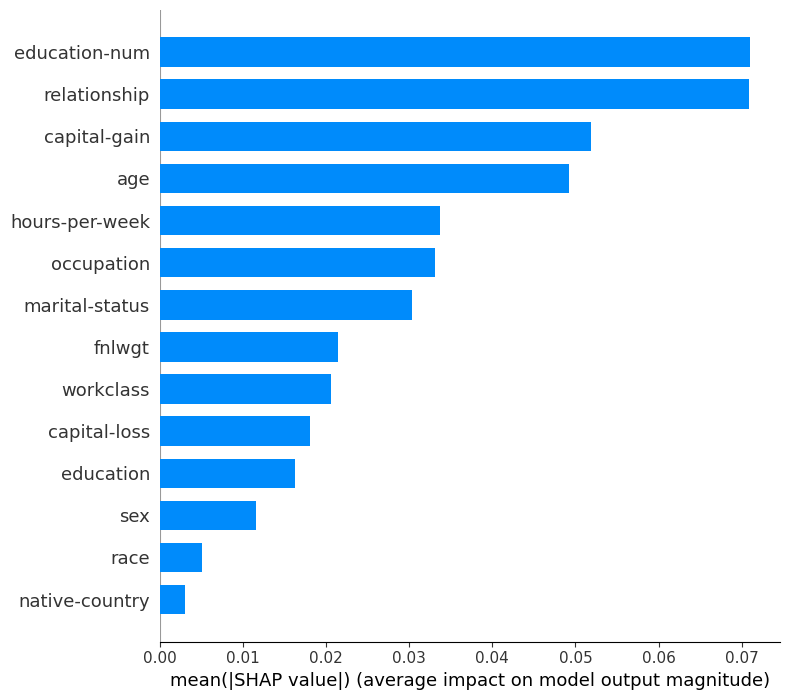

In [51]:
shap.summary_plot(shap_values1.values, X_train, plot_type='bar')


#SHAP For Logistic Regression

In [2]:
from sklearn.linear_model import LogisticRegression

In [23]:
reg = LogisticRegression()
pipeline = Pipeline([
    # ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 9770it [11:58, 13.59it/s]


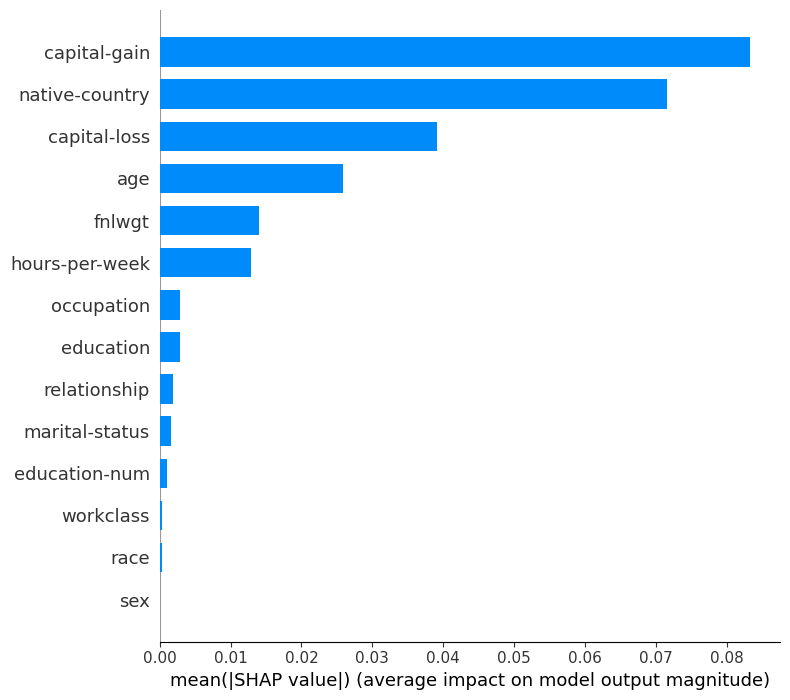

In [26]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')


#SHAP For Best Model in AutoML with partial dependence plots

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_1_AutoML_1_20240318_31348,0.929736,0.27432,0.829615,0.161769,0.294499,0.0867299,30729,0.076109,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20240318_31348,0.929604,0.274533,0.829209,0.167893,0.294644,0.0868152,32058,0.144397,StackedEnsemble
XGBoost_3_AutoML_1_20240318_31348,0.928567,0.276245,0.826846,0.170445,0.295742,0.0874631,5383,0.007056,XGBoost
GBM_3_AutoML_1_20240318_31348,0.928261,0.277168,0.827326,0.170837,0.2957,0.0874387,5433,0.034462,GBM
GBM_2_AutoML_1_20240318_31348,0.928037,0.277743,0.826446,0.165722,0.295979,0.0876037,4336,0.04384,GBM
GBM_4_AutoML_1_20240318_31348,0.926102,0.281138,0.821872,0.167325,0.298023,0.0888179,4527,0.033309,GBM
GBM_1_AutoML_1_20240318_31348,0.925493,0.282354,0.820431,0.158032,0.298873,0.0893251,10835,0.046865,GBM
XGBoost_2_AutoML_1_20240318_31348,0.924449,0.28367,0.817666,0.163506,0.30026,0.0901559,3547,0.007639,XGBoost
XGBoost_1_AutoML_1_20240318_31348,0.921303,0.29043,0.810488,0.173688,0.303384,0.092042,8556,0.008735,XGBoost
XRT_1_AutoML_1_20240318_31348,0.915535,0.302841,0.802551,0.181471,0.308209,0.0949927,8247,0.047462,DRF


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20240318_31348

,0,1,Error,Rate
0,6719.0,750.0,0.1004,(750.0/7469.0)
1,547.0,1777.0,0.2354,(547.0/2324.0)
Total,7266.0,2527.0,0.1324,(1297.0/9793.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

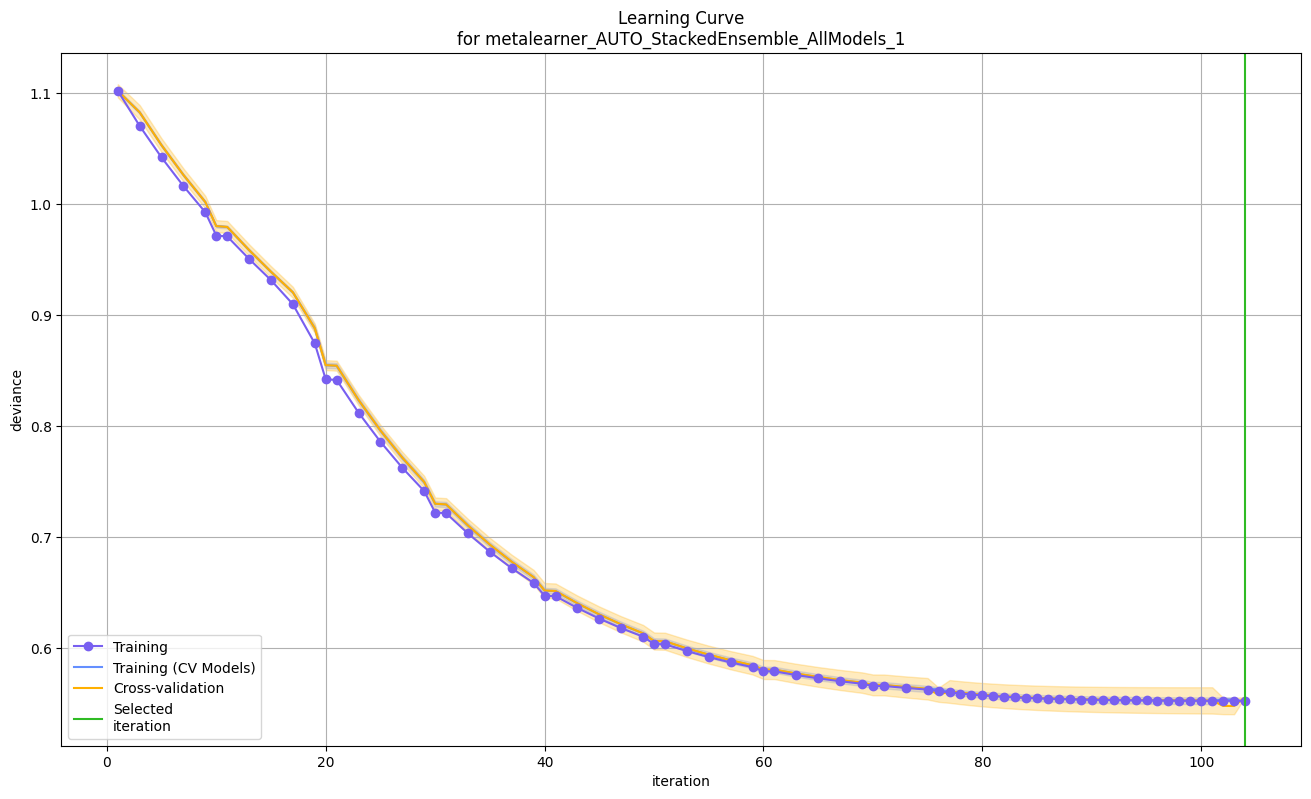

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

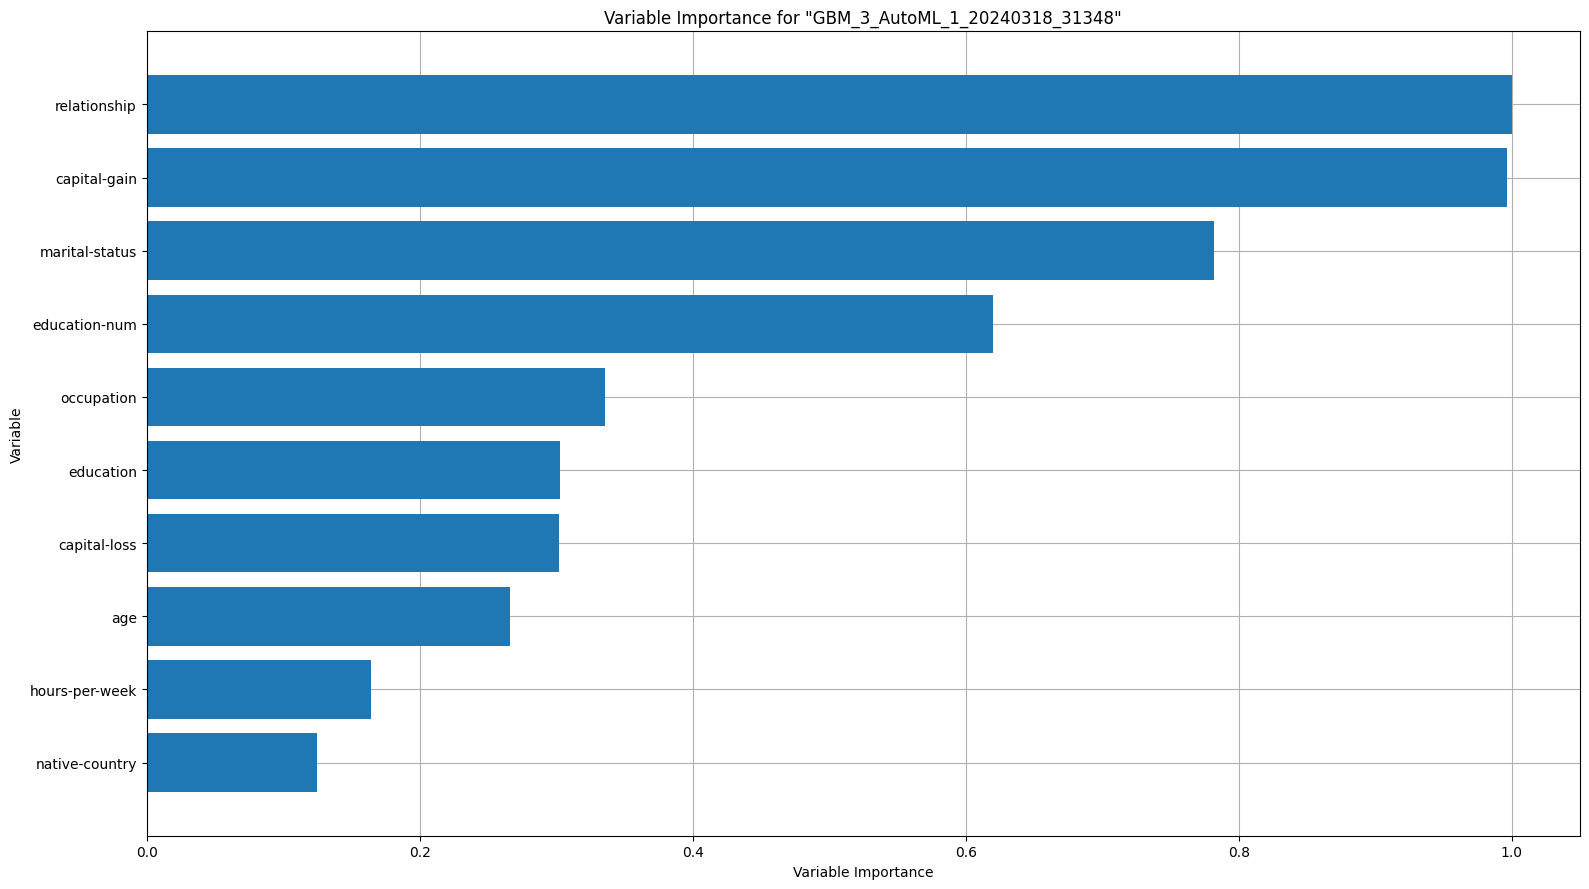

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

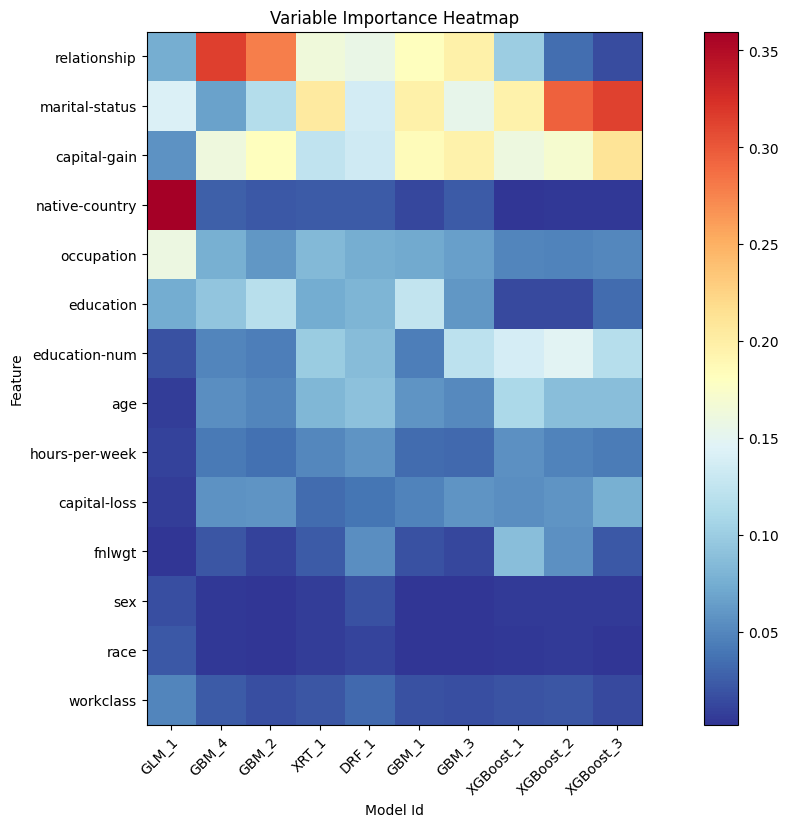

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

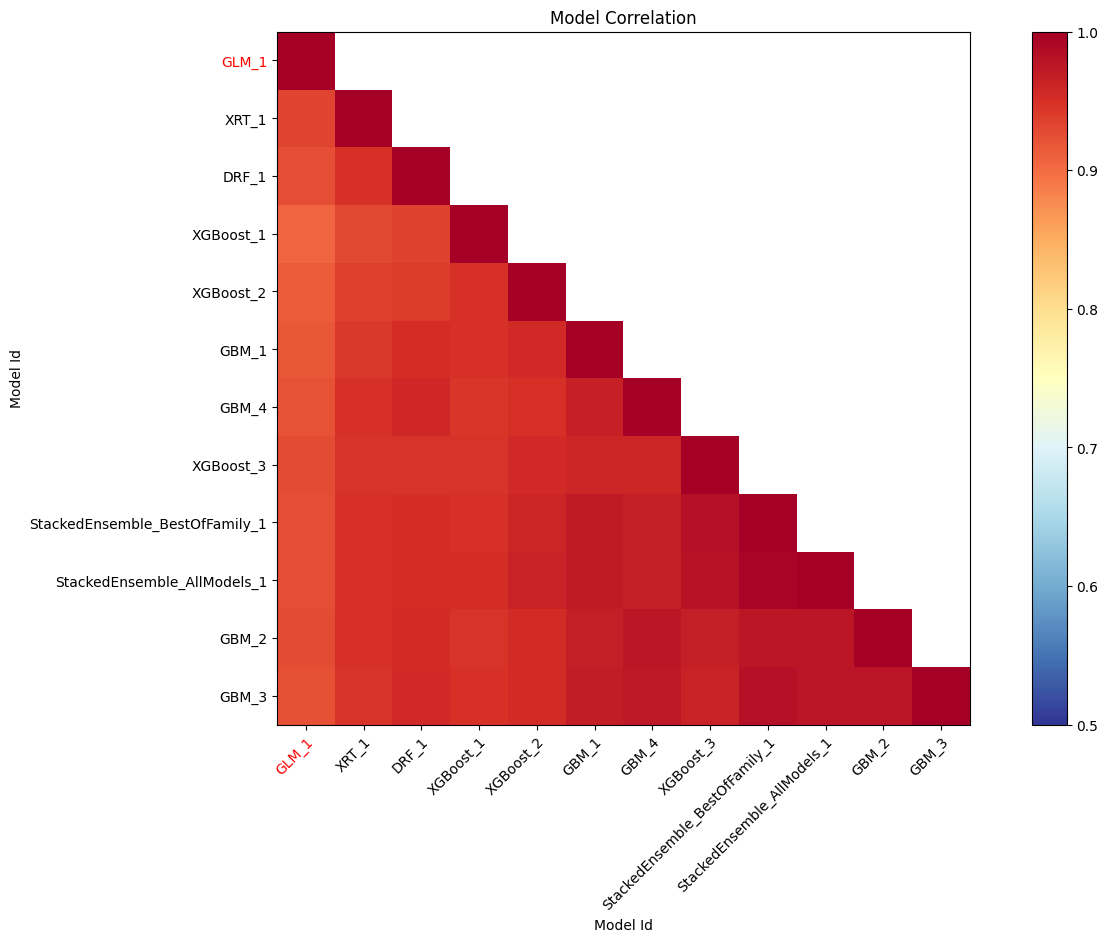

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

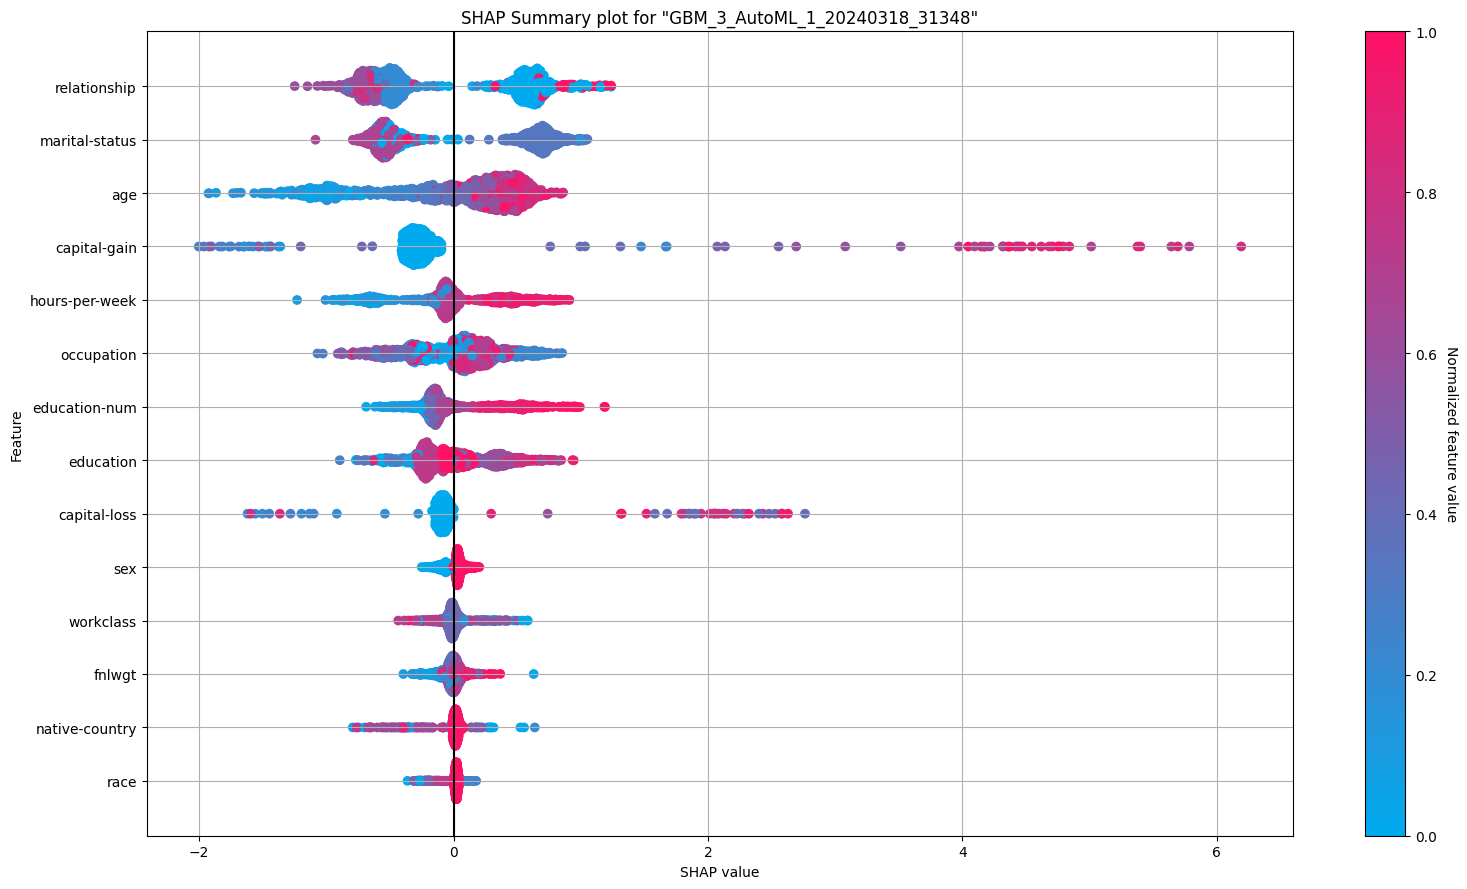

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

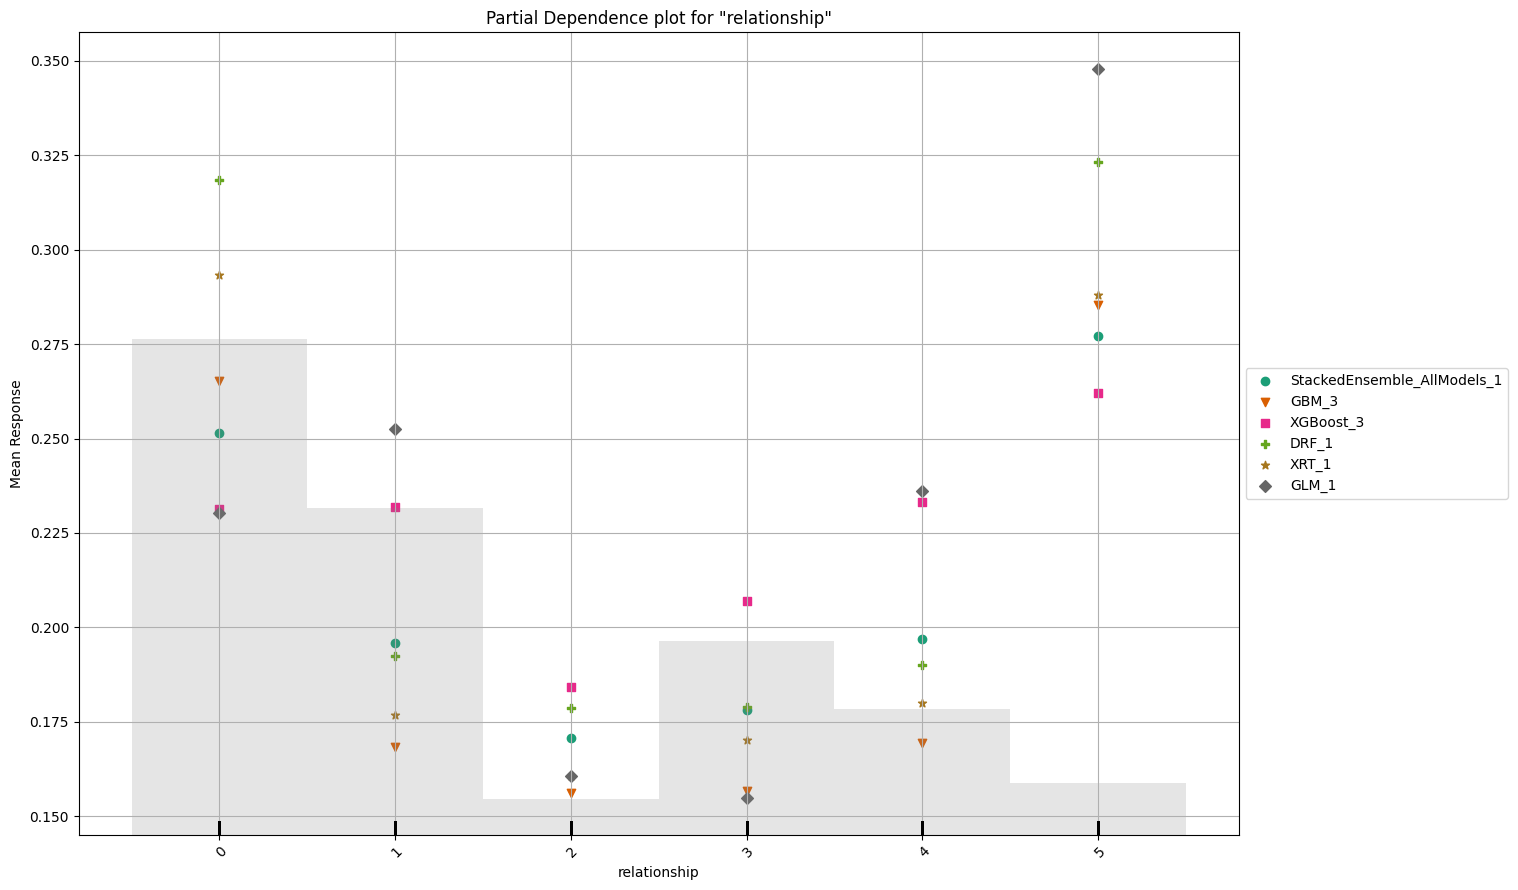

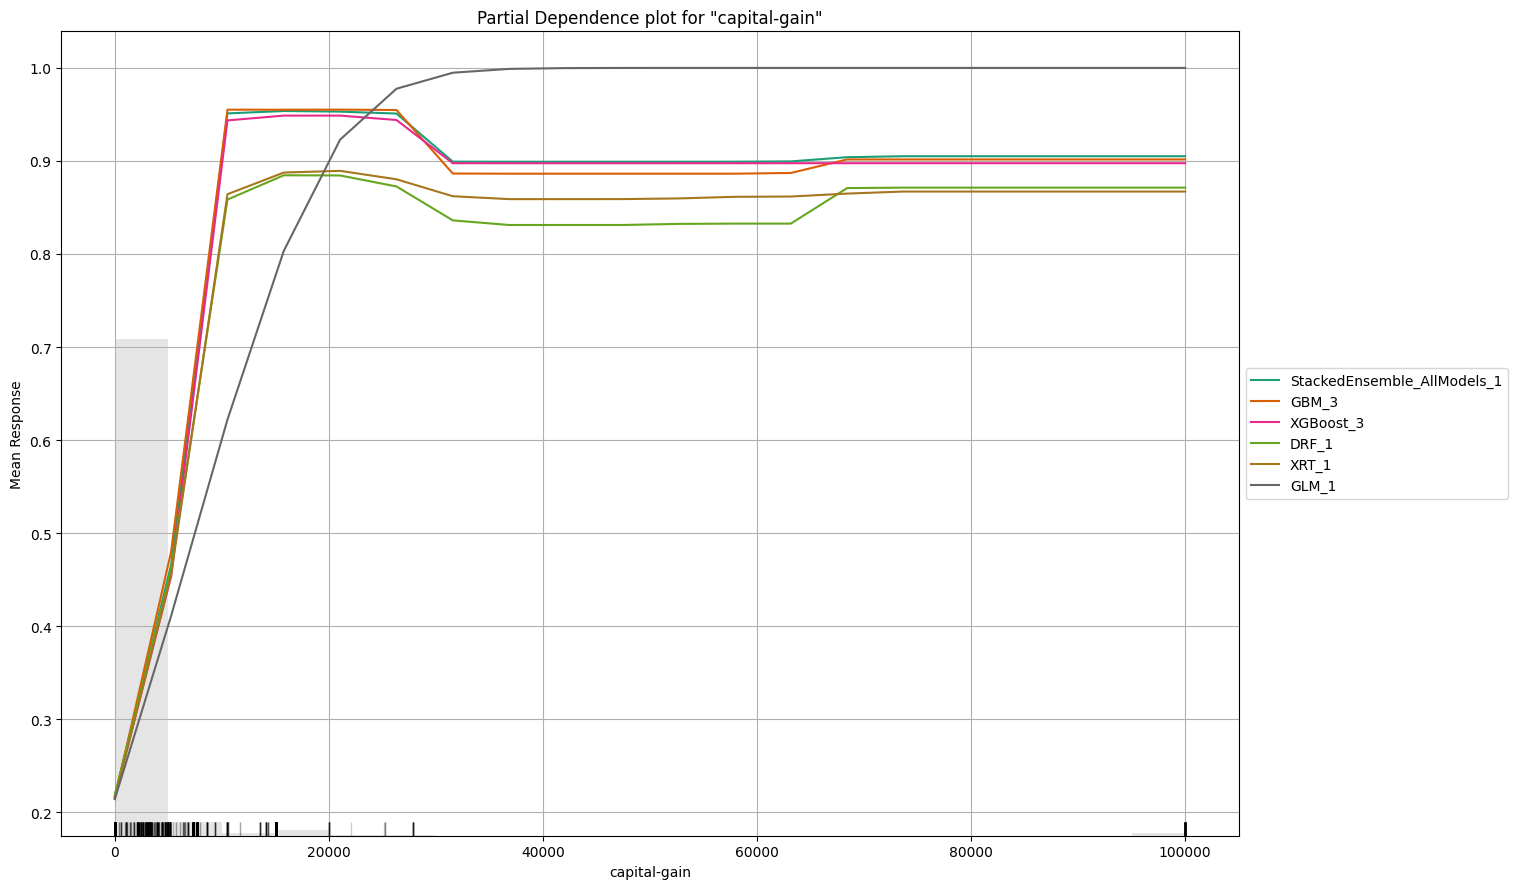

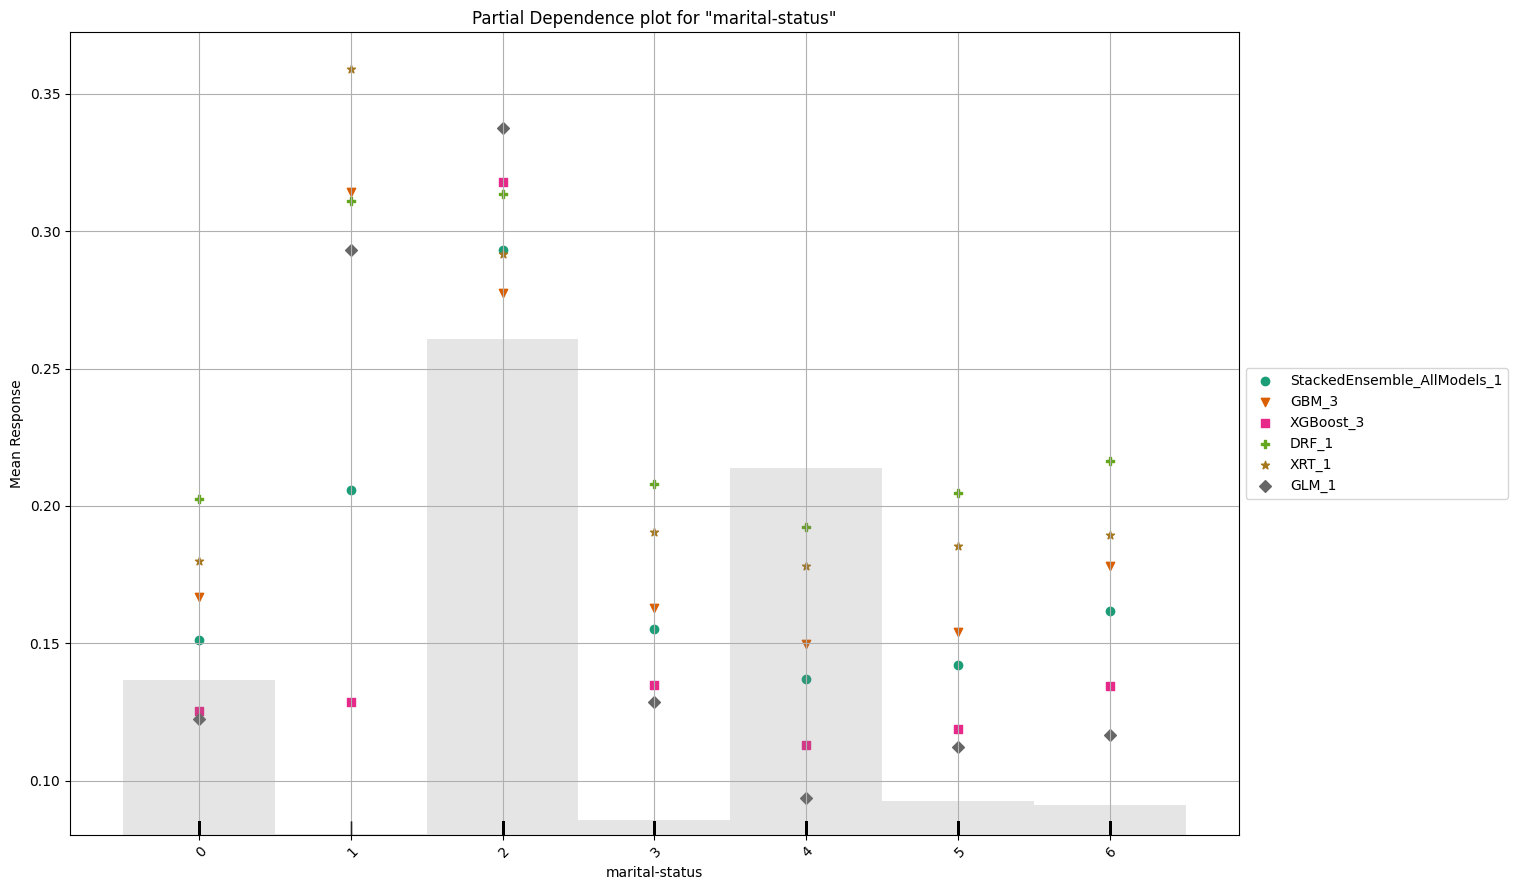

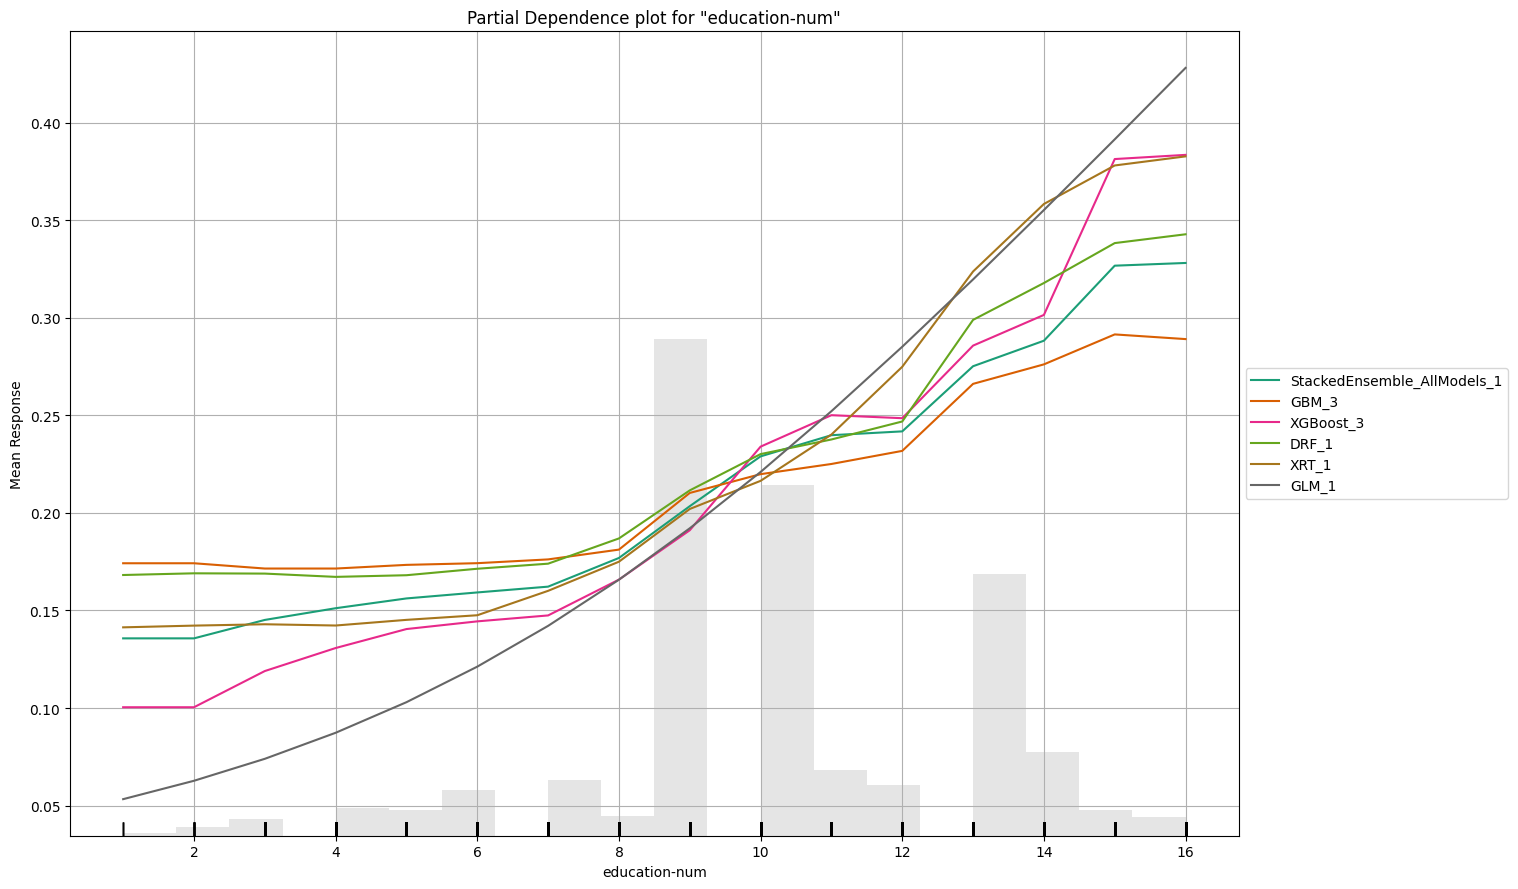

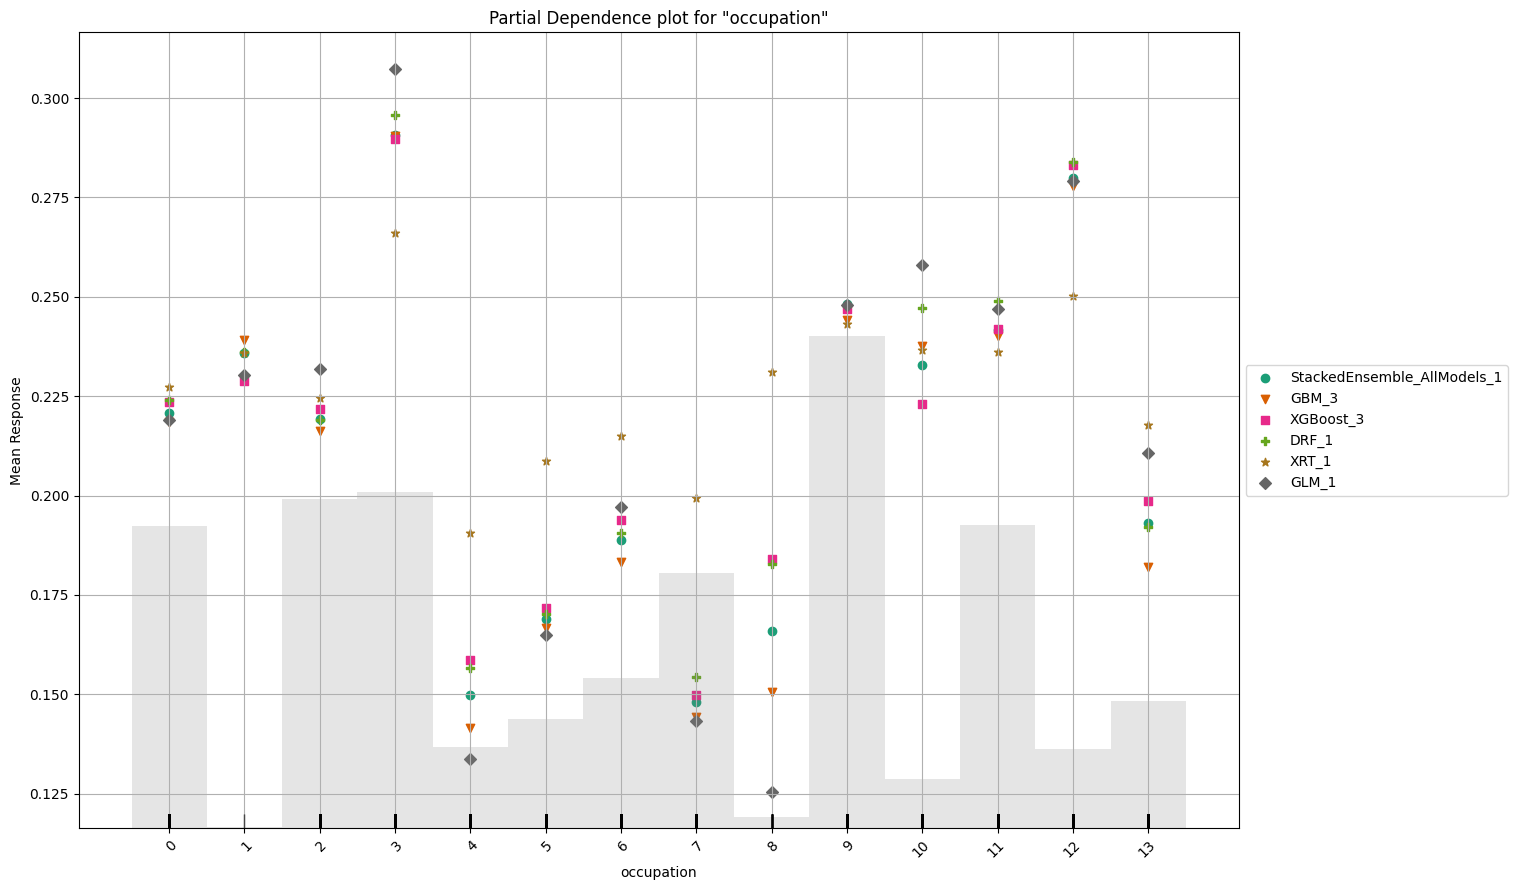

In [40]:
exa = automl.explain(df_test)

#**Insights**

**Permutation Feature Importance**

1) Random Forest

The Best 3 columns:

*   Education-Num
*   Relationship
*   Capital-Gain

2) Logistic Regression

The Best 3 columns:

*   Capital-Gain
*   Native-Country
*   Capital-Loss

3) Stacked Ensemble -AutoML

The Best 3 columns:

*   Relationship
*   Capital-Gain
*   Martial-Status


From these partial Dependence plots,
I can see that the model's prediction is more sensitive to "capital-gain" for lower values.
Age is easily predictable in this model which once again proves the fact that higher the experience leads to higher the income.


# **Conclusion**
Compared with every other feature importance { Capital-Gain, Relationship } plays a major role in classifying the categories.

The Stacked Ensemble model using AutoML gave performance in binary classification, with a high AUC of 0.942.

# **References**


1.   https://docs.h2o.ai/h2o/latest-stable/h2o-docs/

2.   https://towardsdatascience.com/a-deep-dive-into-h2os-automl-4b1fe51d3f3e

3.  My previous assignment


MIT License

Copyright (c) 2024 Ramshankar-Bhuvaneswaran

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.